## **Heart Disease Prediction using Logistic Regression, Decision Tree and Artificial Neural Network (ANN)**

### __Importing Dataset__

The dataset was obtained from https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease. It is about the Key Heart Disease Indicators, sourced from the 2022 CDC survey involving over 400,000 adults, which primarily examines health-related factors that cause heart disease. Globally, heart disease ranks among the top causes of death across different racial groups, with major risk factors such as high blood pressure, high cholesterol levels, and smoking. Other significant contributors to heart disease include diabetes, obesity, lack of physical activity, and excessive alcohol consumption are taken into consideration. 

In [1]:
#importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import data_visualization as dv
import data_preprocessing as dp
import warnings

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, LeakyReLU, BatchNormalization
from sklearn.model_selection import GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor

warnings.filterwarnings("ignore")

In [2]:
# Open file for heart disease key indicators
heart_disease_df=pd.read_csv("dataset/heart_2022_with_nans.csv")
heart_disease_df.head(5)

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,Alabama,Female,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,8.0,NaN,No,...,NaN,NaN,NaN,No,No,Yes,No,"Yes, received tetanus shot but not sure what type",No,No
1,Alabama,Female,Excellent,0.0,0.0,NaN,No,6.0,NaN,No,...,1.60,68.04,26.57,No,No,No,No,"No, did not receive any tetanus shot in the pa...",No,No
2,Alabama,Female,Very good,2.0,3.0,Within past year (anytime less than 12 months ...,Yes,5.0,NaN,No,...,1.57,63.50,25.61,No,No,No,No,NaN,No,Yes
3,Alabama,Female,Excellent,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,7.0,NaN,No,...,1.65,63.50,23.30,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,No
4,Alabama,Female,Fair,2.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,NaN,No,...,1.57,53.98,21.77,Yes,No,No,Yes,"No, did not receive any tetanus shot in the pa...",No,No


In [3]:
heart_disease_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445132 entries, 0 to 445131
Data columns (total 40 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   State                      445132 non-null  object 
 1   Sex                        445132 non-null  object 
 2   GeneralHealth              443934 non-null  object 
 3   PhysicalHealthDays         434205 non-null  float64
 4   MentalHealthDays           436065 non-null  float64
 5   LastCheckupTime            436824 non-null  object 
 6   PhysicalActivities         444039 non-null  object 
 7   SleepHours                 439679 non-null  float64
 8   RemovedTeeth               433772 non-null  object 
 9   HadHeartAttack             442067 non-null  object 
 10  HadAngina                  440727 non-null  object 
 11  HadStroke                  443575 non-null  object 
 12  HadAsthma                  443359 non-null  object 
 13  HadSkinCancer              44

We'll use the same set of features* (18 in total) from the 2020 dataset to simplify the analysis. Therefore, we'll exclude additional features introduced in the 2022 dataset, except for `HeightInMeters` and `WeightInKilograms`. These two features are important for calculating missing values in the `BMI` field.

In [4]:
del_columns = ['State', 'LastCheckupTime', 'RemovedTeeth', 'HadDepressiveDisorder', 'HadArthritis', 'HadAngina', 'HadCOPD', 
               'DeafOrHardOfHearing', 'ECigaretteUsage', 'BlindOrVisionDifficulty', 'DifficultyConcentrating', 'ChestScan',
               'DifficultyDressingBathing', 'DifficultyErrands', 'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver', 'CovidPos',
               'TetanusLast10Tdap', 'HighRiskLastYear']

heart_disease_df = heart_disease_df.drop(columns=del_columns)
print(f"Number of features: {len(heart_disease_df.columns)}")

Number of features: 20


In [5]:
# Dimension of the dataset
print(f"Shape of the Heart Disease dataset: ({heart_disease_df.shape})")

Shape of the Heart Disease dataset: ((445132, 20))


### __Exploratory Data Analysis__

View the generate descriptive statistics of the dataset

In [6]:
heart_disease_df.describe()

,PhysicalHealthDays,MentalHealthDays,SleepHours,HeightInMeters,WeightInKilograms,BMI
count,434205.000000,436065.000000,439679.000000,416480.000000,403054.000000,396326.000000
mean,4.347919,4.382649,7.022983,1.702691,83.074470,28.529842
std,8.688912,8.387475,1.502425,0.107177,21.448173,6.554889
min,0.000000,0.000000,1.000000,0.910000,22.680000,12.020000
25%,0.000000,0.000000,6.000000,1.630000,68.040000,24.130000
50%,0.000000,0.000000,7.000000,1.700000,80.740000,27.440000
75%,3.000000,5.000000,8.000000,1.780000,95.250000,31.750000
max,30.000000,30.000000,24.000000,2.410000,292.570000,99.640000


Drop all duplicate records from the dataset

In [7]:
print(f"Record count before dropping duplicates => {heart_disease_df.shape[0]}")
heart_disease_df = heart_disease_df.drop_duplicates()
print(f"Record count after dropping duplicates  => {heart_disease_df.shape[0]}")

Record count before dropping duplicates => 445132
Record count after dropping duplicates  => 431009


Check all records with missing (or null) values

In [8]:
print("List of features with missing values:")
heart_disease_df.isna().sum()

List of features with missing values:
- 'GeneralHealth' : 1175
- 'PhysicalHealthDays' : 10897
- 'MentalHealthDays' : 9038
- 'PhysicalActivities' : 1069
- 'SleepHours' : 5413
- 'HadHeartAttack' : 3038
- 'HadStroke' : 1530
- 'HadAsthma' : 1746
- 'HadSkinCancer' : 3116
- 'HadKidneyDisease' : 1899
- 'HadDiabetes' : 1060
- 'DifficultyWalking' : 19808
- 'SmokerStatus' : 31136
- 'RaceEthnicityCategory' : 13740
- 'AgeCategory' : 8444
- 'HeightInMeters' : 23814
- 'WeightInKilograms' : 36714
- 'BMI' : 43426
- 'AlcoholDrinkers' : 42185


There are 3,038 records with missing values found in `HadHeartAttack`, which is the target variable. Hence, we can simply drop all those records, keeping only the records with assigned class labels.

In [9]:
print(f"Record count before dropping null values in 'HadHeartAttack' => {heart_disease_df.shape[0]}")
heart_disease_df = heart_disease_df.dropna(subset=["HadHeartAttack"])
print(f"Record count after dropping null values in 'HadHeartAttack'  => {heart_disease_df.shape[0]}")


Record count before dropping null values in 'HadHeartAttack' => 431009
Record count after dropping null values in 'HadHeartAttack'  => 427971


Check if the target variable `HadHeartAttack` is a binary, wherein it should only have two distinct values, i.e. Yes and No. This feature will be used to predict whether a person has heart disease or not.

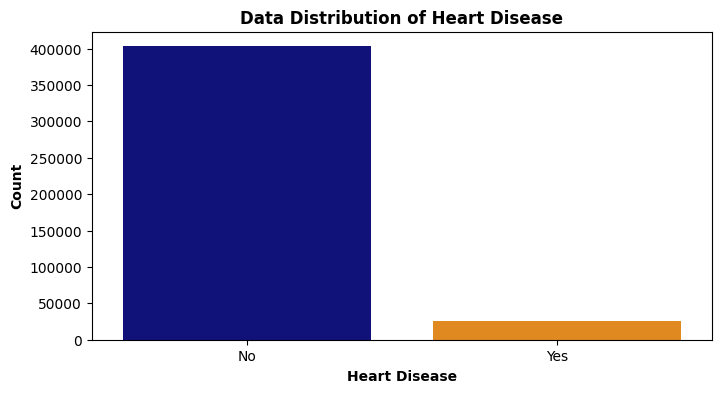

In [10]:
dv.show_bar_graph(df=heart_disease_df,
                  col_="HadHeartAttack",
                  figure_size=(8, 4),
                  title='Data Distribution of Heart Disease',
                  x_label='Heart Disease',
                  y_label='Count',
                  x_tick_rotation=None,
                  bar_color=['darkblue', 'darkorange'])

__Observation:__ The chart reveals that there is an imbalance in the number of records for `HadHeartAttack`, showing an uneven distribution of data between individuals who have the illness and those who do not. This could cause the trained model's predictions for heart disease to be severely biased. Ways to fix imbalanced dataset include oversampling minority class, undersampling majority class, adding class weight, generating synthetic samples, etc. In our case, we will be using SMOTE (Synthetic Minority Oversampling Technique) approach to avoid losing information from the majority class. The key idea behind SMOTE is to oversample the minority class by generating synthetic examples.

##### __Limiting Data to a Specific Ethnicity__

When building a model for heart disease, considering a particular ethnicity is very important because different ethnic groups can have distinct genetic, lifestyle, and environmental factors that influence the health of the heart. By focusing on a specific ethnicity, we can develop more personalized and accurate models that account for unique risk factors and characteristics within that population.

In [11]:
ethnicity_df = heart_disease_df["RaceEthnicityCategory"].value_counts(dropna=False).reset_index()
ethnicity_df.columns = ["RaceEthnicityCategory", "count"]

print(ethnicity_df)

           RaceEthnicityCategory   count
0       White only, Non-Hispanic  306097
1                       Hispanic   41980
2       Black only, Non-Hispanic   34793
3  Other race only, Non-Hispanic   22195
4                            NaN   13408
5      Multiracial, Non-Hispanic    9498


Therefore, we'll focus solely on the majority of the racial groups, which is `White only, Non-Hispanic`.

In [13]:
print(f"Record count before dropping null values in 'RaceEthnicityCategory' => {heart_disease_df.shape[0]}")
heart_disease_df = heart_disease_df[heart_disease_df['RaceEthnicityCategory'] == 'White only, Non-Hispanic']
print(f"Record count after filtering for 'White only, Non-Hispanic' in 'RaceEthnicityCategory' => {heart_disease_df.shape[0]}")

Record count before dropping null values in 'RaceEthnicityCategory' => 427971
Record count after filtering for 'White only, Non-Hispanic' in 'RaceEthnicityCategory' => 319505


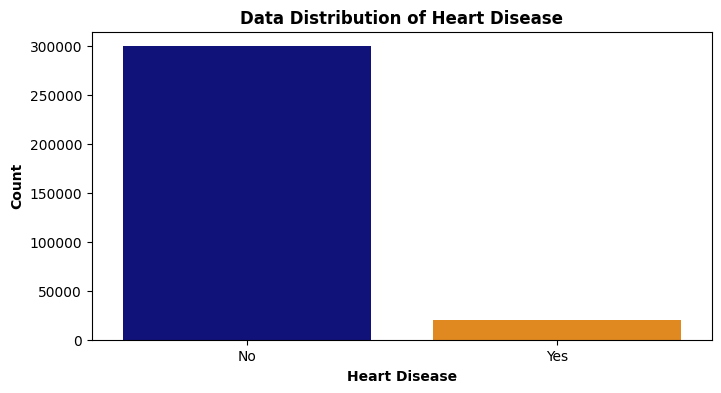

In [14]:
dv.show_bar_graph(df=heart_disease_df,
                  col_="HadHeartAttack",
                  figure_size=(8, 4),
                  title='Data Distribution of Heart Disease',
                  x_label='Heart Disease',
                  y_label='Count',
                  x_tick_rotation=None,
                  bar_color=['darkblue', 'darkorange'])

##### __Data Imputation for Missing Values__

Data imputation involves completing or substituting missing values within a dataset. The significance of data imputation lies in its ability to enhance the completeness and reliability of the dataset, ensuring a more comprehensive and accurate representation of the underlying information.

----------------


__i. Data Imputatifor Height and Weight__

Check the skewness of `HeightInMeters` and `WeightInKilograms` within each age category to decide on the appropriate imputation method. Based from the results, majority of height values are slightly skewed to the left, while all weight values are skewed to the right. Therefore, the __*median*__ for each sex and age category group will be used to address the missing values for both height and weight since median is more sensitive to outliers than the mean.

*Example: Female in age 18 to 24 age category has a median height of 1.65 meters and weight of 66.22 kilograms. Hence, these values for will be imputed on missing values in height and weight given this specific group.*

__Skewness Interpretation:__
- If skewness is close to 0, it suggests a relatively symmetrical distribution.
- If skewness is significantly positive, it indicates a right-skewed distribution.
- If skewness is significantly negative, it indicates a left-skewed distribution.

In [15]:
# Replace null values in 'AgeCategory' with a placeholder value (e.g., 'Unknown')
heart_disease_df['AgeCategory'] = heart_disease_df['AgeCategory'].fillna('Unknown')

# Group by 'Sex' and 'AgeCategory' and calculate statistics
skewness_df = heart_disease_df.groupby(['Sex', 'AgeCategory']).agg({
    'HeightInMeters': ['skew', 'count', 'median'],
    'WeightInKilograms': ['skew', 'count', 'median']
}).reset_index()

# Rename columns for clarity
skewness_df.columns = ['Sex', 'AgeCategory', 'HeightSkewness', 'HeightCount', 'HeightMedian', 'WeightSkewness', 'WeightCount', 'WeightMedian']


print("Statistical analysis on height and weight based on sex and age category")
skewness_df

Statistical analysis on height and weight based on sex and age category


,Sex,AgeCategory,HeightSkewness,HeightCount,HeightMedian,WeightSkewness,WeightCount,WeightMedian
0,Female,Age 18 to 24,-0.024190,6211,1.65,1.350301,6007,66.22
1,Female,Age 25 to 29,0.063605,5634,1.65,1.262882,5459,72.57
2,Female,Age 30 to 34,0.111134,7317,1.65,1.360200,6992,72.57
3,Female,Age 35 to 39,0.103533,8661,1.65,1.399253,8218,73.48
4,Female,Age 40 to 44,-0.151946,9568,1.65,1.335167,9027,74.84
5,Female,Age 45 to 49,-0.002063,9415,1.65,1.423931,8796,76.20
6,Female,Age 50 to 54,0.059083,11817,1.65,1.225314,10970,77.11
7,Female,Age 55 to 59,-0.101341,13508,1.65,1.132338,12468,74.84
8,Female,Age 60 to 64,-0.080895,17428,1.65,1.101860,16182,74.84
9,Female,Age 65 to 69,0.089143,18758,1.63,1.120694,17353,72.57


In [16]:
# Check for missing values
missing_val_height = heart_disease_df["HeightInMeters"].isnull().sum()
missing_val_weight = heart_disease_df["WeightInKilograms"].isnull().sum()
print(f"Check for missing values in `HeightInMeters` before imputation: {missing_val_height} and `WeightInKilograms` before imputation: {missing_val_weight}")

# Median imputation for Height and Weight
heart_disease_df = dp.impute_biometrics(heart_disease_df, skewness_df, "HeightInMeters", "HeightMedian")
heart_disease_df = dp.impute_biometrics(heart_disease_df, skewness_df, "WeightInKilograms", "WeightMedian")

# Check for missing values
missing_val_height = heart_disease_df["HeightInMeters"].isnull().sum()
missing_val_weight = heart_disease_df["WeightInKilograms"].isnull().sum()
print(f"Check for missing values in `HeightInMeters`: {missing_val_height} and `WeightInKilograms`: {missing_val_weight}")

Check for missing values in `HeightInMeters` before imputation: 14470 and `WeightInKilograms` before imputation: 25978
Check for missing values in `HeightInMeters`: 0 and `WeightInKilograms`: 0


__ii. Data Imputation for BMI__

Body Mass Index (BMI) is a metric calculated based on a person's weight and height. The BMI is often used as an indicator of body fatness and is a screening tool to categorize individuals into different weight status categories, such as underweight, normal weight, overweight, and obesity. The formula is:

$$ BMI = {WeightInKilograms \over HeightInMeters^2} $$

To fill in the missing BMI, we will calculate BMI by using a person's weight and height given formula above.

In [17]:
print(f"Record count with missing BMI before data imputation => {heart_disease_df['BMI'].isnull().sum()}")
heart_disease_df=dp.impute_bmi(heart_disease_df)
print(f"Record count with missing BMI after data imputation  => {heart_disease_df['BMI'].isnull().sum()}")

Record count with missing BMI before data imputation => 29266
Record count with missing BMI after data imputation  => 0


We use boxplot to check whether any outliers present in the BMI column. From the chart, a number of outliers are shown. However, we'll just consider the data as outlier if BMI value is more than 100.

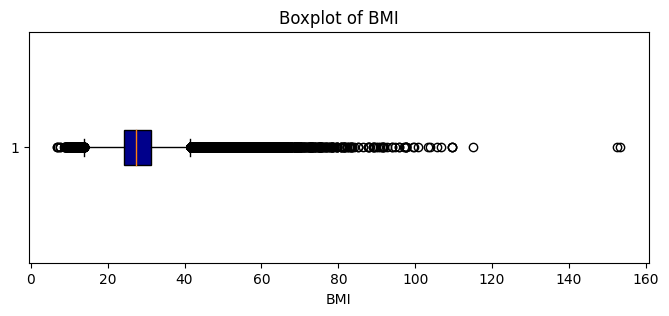

In [18]:
bmi_data = heart_disease_df['BMI'].dropna().tolist()
dv.show_boxplot_graph(data=bmi_data, figure_size=(8,3),title='Boxplot of BMI', x_label='BMI')

In [19]:
# Remove outliers from BMI dataset, i.e. BMI greater 100
heart_disease_df = heart_disease_df[heart_disease_df['BMI'] <= 100]
print(f"Min BMI: {heart_disease_df['BMI'].min()}, Max BMI: {heart_disease_df['BMI'].max()}")

Min BMI: 6.768013327780092, Max BMI: 99.64


__iii. Data Imputation for Age Category__

To fill in the missing age group values, a new column named `WeightStatus` will be created. Its value will be derived from the BMI column. BMI interpretation is based on guidelines available at https://www.cdc.gov/healthyweight/assessing/bmi/adult_bmi/index.html." 
- Underweight: 0 to 18.59
- Healthy Weight: 18.6 to 24.99
- Overweight: 25.0 to 29.99
- Obesity: 30.0 and above

This new column will be part of the aggregation to get the age category with the highest count per group.

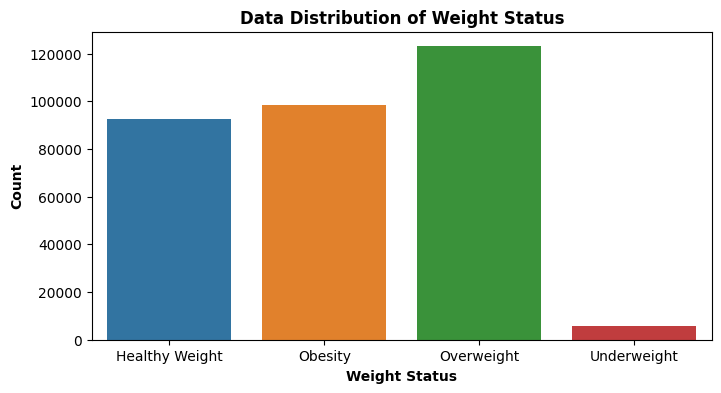

In [20]:
# Create a new column `WeightStatus` with values based on BMI
conditions = [
    (heart_disease_df['BMI'].between(0, 18.6)),
    (heart_disease_df['BMI'].between(18.6, 25.0)),
    (heart_disease_df['BMI'].between(25.0, 30.0)),
    (heart_disease_df['BMI'] >= 30.0)
]

choices = ["Underweight", "Healthy Weight", "Overweight", "Obesity"]

heart_disease_df['WeightStatus'] = np.select(conditions, choices)

# Show data distribution of weight status
dv.show_bar_graph(df=heart_disease_df, 
                  col_="WeightStatus", 
                  figure_size=(8,4),
                  title='Data Distribution of Weight Status', 
                  x_label='Weight Status', 
                  y_label='Count', 
                  x_tick_rotation=None)

For each combination of `Sex`, `WeightStatus`, and `AgeCategory`, the code identifies rows with the highest frequency by using a window function to find the maximum count within each subgroup. The missing data in the `AgeCategory` will be imputed based on the subgroup.

*Example: Majority of underweight females fall into the 'Age 80 or older' category. Hence, that specific age category value will be used to replace the missing data for underweight females.*

In [21]:
print("Statistical analysis for age group based on sex and weight status")
age_result = dp.get_statistical_analysis(heart_disease_df, "Sex", "WeightStatus", "AgeCategory")
age_result

Statistical analysis for age group based on sex and weight status


,Sex,WeightStatus,AgeCategory,count
12,Female,Healthy Weight,Age 80 or older,7862
23,Female,Obesity,Age 65 to 69,6170
37,Female,Overweight,Age 65 to 69,7174
54,Female,Underweight,Age 80 or older,729
56,Male,Healthy Weight,Age 18 to 24,4279
79,Male,Obesity,Age 65 to 69,6011
93,Male,Overweight,Age 65 to 69,7537
98,Male,Underweight,Age 18 to 24,420


In [22]:
# Converting the 'Unknown' values in AgeCategory column back to null values
heart_disease_df['AgeCategory'] = heart_disease_df['AgeCategory'].replace('Unknown', np.nan)

Number of Null Values in AgeCategory before imputation:  6412


Number of Null Values in AgeCategory after imputation:  0


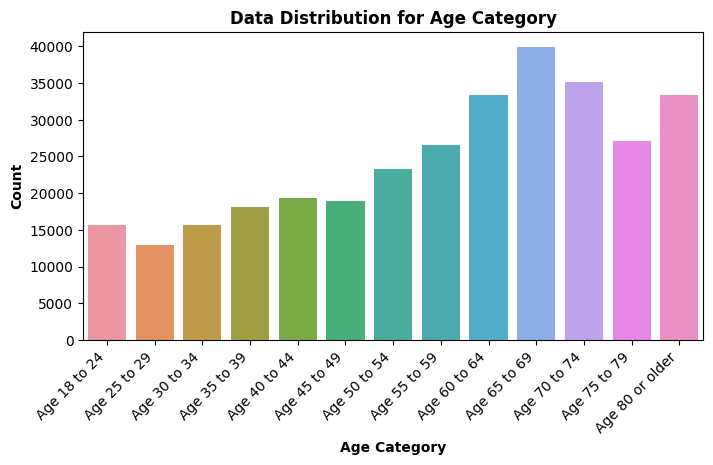

In [23]:
# Impute age category based on sex and weight status
print("Number of Null Values in AgeCategory before imputation: ", heart_disease_df['AgeCategory'].isnull().sum())
heart_disease_df = dp.impute_based_on_sws(heart_disease_df, age_result, "AgeCategory")
print("Number of Null Values in AgeCategory after imputation: ", heart_disease_df['AgeCategory'].isnull().sum())

# Show data distribution of age category
dv.show_bar_graph(df=heart_disease_df, 
                  col_="AgeCategory", 
                  figure_size=(8,4),
                  title='Data Distribution for Age Category', 
                  x_label='Age Category',
                  y_label='Count', 
                  x_tick_rotation=45)

__iv. Data Imputation for General Health__

For each combination of `Sex`, `WeightStatus`, and `GeneralHealth`, the code identifies rows with the highest frequency by using a window function to find the maximum count within each subgroup. The missing data in the `GeneralHealth` will be imputed based on the subgroup.

*Example: Majority of underweight females fall into the 'Very Good' health. Hence, that specific general health category value will be used to replace the missing data for underweight females.*

In [24]:
print("Statistical analysis for general health based on sex and weight status")
genhealth_result = dp.get_statistical_analysis(heart_disease_df, "Sex", "WeightStatus", "GeneralHealth")
genhealth_result

Statistical analysis for general health based on sex and weight status


,Sex,WeightStatus,GeneralHealth,count
4,Female,Healthy Weight,Very good,22065
7,Female,Obesity,Good,19732
14,Female,Overweight,Very good,22648
19,Female,Underweight,Very good,1170
24,Male,Healthy Weight,Very good,13088
27,Male,Obesity,Good,18831
34,Male,Overweight,Very good,23925
37,Male,Underweight,Good,504


In [25]:
# Impute general health based on sex and weight status
print("Number of null values in General Health before imputation: ", heart_disease_df['GeneralHealth'].isnull().sum())
heart_disease_df = dp.impute_based_on_sws(heart_disease_df, genhealth_result, "GeneralHealth")
print("Number of null values in General Health after imputation: ", heart_disease_df['GeneralHealth'].isnull().sum())

Number of Null values in General Health before imputation:  767
Number of Null values in General Health after imputation:  0


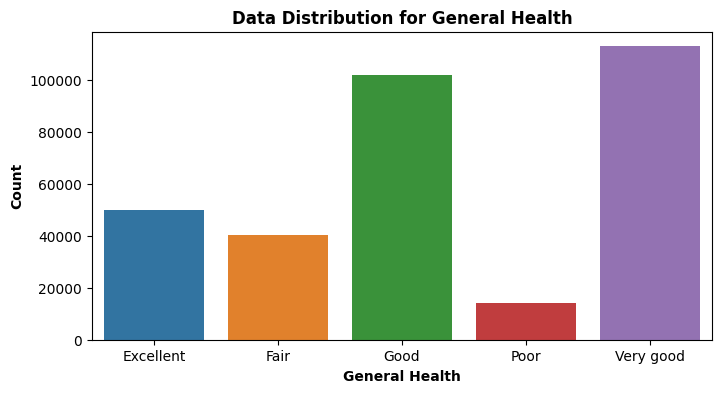

In [26]:
# Show data distribution for general health
dv.show_bar_graph(df=heart_disease_df, 
                  col_="GeneralHealth", 
                  figure_size=(8,4),
                  title='Data Distribution for General Health', 
                  x_label='General Health',
                  y_label='Count')

__v. Data Imputation for Having Diabetes__

For each combination of `Sex`, `AgeCategory`, and `HadDiabetes`, the code identifies rows with the highest frequency by using a window function to find the maximum count within each subgroup. The missing data in the `HadDiabetes` will be imputed based on the subgroup. Based from the results from the table below, all missing values in `HadDiabetes` will be replaced by 'No'.

__NOTE:__ Same approach will be utilized for subsequent data imputations.

In [27]:
print("Statistical analysis for having diabetes based on sex and age category")
diabetes_result = dp.get_statistical_analysis(heart_disease_df, "Sex", "AgeCategory", "HadDiabetes")
diabetes_result

Statistical analysis for having diabetes based on sex and age category


,Sex,AgeCategory,HadDiabetes,count
0,Female,Age 18 to 24,No,6335
4,Female,Age 25 to 29,No,5649
8,Female,Age 30 to 34,No,7132
12,Female,Age 35 to 39,No,8314
16,Female,Age 40 to 44,No,8998
20,Female,Age 45 to 49,No,8727
24,Female,Age 50 to 54,No,10534
28,Female,Age 55 to 59,No,11737
32,Female,Age 60 to 64,No,14850
36,Female,Age 65 to 69,No,16383


In [28]:
print("Number of null values in HadDiabetes before imputation: ", heart_disease_df['HadDiabetes'].isnull().sum())
# Impute all missing values with 'No' for all sex and age category
heart_disease_df = heart_disease_df.fillna({'HadDiabetes': 'No'})
print("Number of null values in HadDiabetes after imputation: ", heart_disease_df['HadDiabetes'].isnull().sum())

Number of Null values in HadDiabetes before imputation:  485
Number of Null values in HadDiabetes after imputation:  0


In [29]:
# Show unique values under smoker status column
heart_disease_df['HadDiabetes'].value_counts().unique

<bound method Series.unique of No                                         267388
Yes                                         42884
No, pre-diabetes or borderline diabetes      6583
Yes, but only during pregnancy (female)      2639
Name: HadDiabetes, dtype: int64>

Combine 'No, pre-diabetes or borderline diabetes' with 'No', and 'Yes, but only during pregnancy (female)' with 'Yes' in `HadDiabetes`

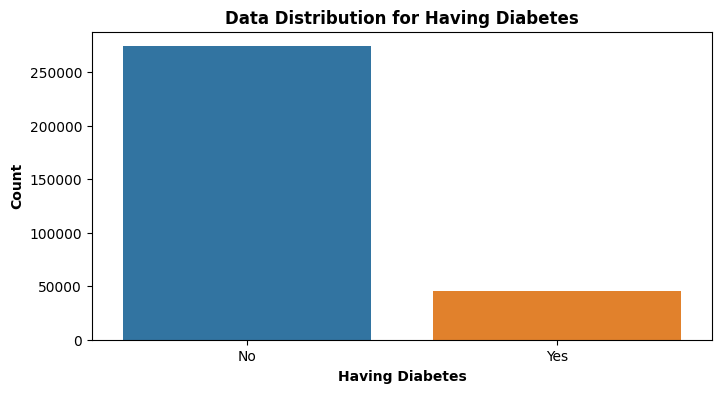

In [30]:
heart_disease_df["HadDiabetes"] = heart_disease_df["HadDiabetes"].apply(
    lambda x: "No" if x == "No, pre-diabetes or borderline diabetes" else (
        "Yes" if x == "Yes, but only during pregnancy (female)" else x
    )
)

# Show data distribution for having diabetes
dv.show_bar_graph(df=heart_disease_df, 
                  col_="HadDiabetes", 
                  figure_size=(8,4),
                  title='Data Distribution for Having Diabetes', 
                  x_label='Having Diabetes',
                  y_label='Count')

__vi. Data Imputation for Having Stroke__

Based from results in the table below, all missing values in `HadStroke` will be replaced by 'No'.

In [31]:
print("Statistical analysis for having stroke based on sex and age category")
stroke_result = dp.get_statistical_analysis(heart_disease_df, "Sex", "AgeCategory", "HadStroke")
stroke_result

Statistical analysis for having stroke based on sex and age category


,Sex,AgeCategory,HadStroke,count
0,Female,Age 18 to 24,No,6507
2,Female,Age 25 to 29,No,5901
4,Female,Age 30 to 34,No,7657
6,Female,Age 35 to 39,No,8982
8,Female,Age 40 to 44,No,9826
10,Female,Age 45 to 49,No,9668
12,Female,Age 50 to 54,No,11995
14,Female,Age 55 to 59,No,13605
16,Female,Age 60 to 64,No,17355
18,Female,Age 65 to 69,No,19502


In [32]:
print("Number of Null values in HadStroke before imputation: ", heart_disease_df['HadStroke'].isnull().sum())
# Impute all missing values with 'No' for all sex and age category
heart_disease_df = heart_disease_df.fillna({'HadStroke': 'No'})
print("Number of Null values in HadStroke after imputation: ", heart_disease_df['HadStroke'].isnull().sum())

Number of Null values in HadStroke before imputation:  804
Number of Null values in HadStroke after imputation:  0


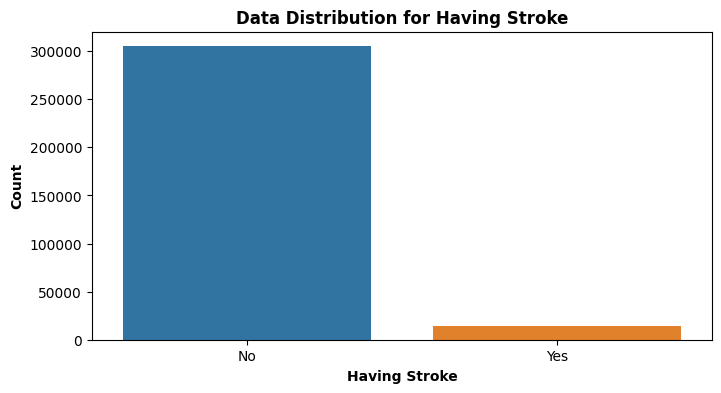

In [33]:
# Show data distribution for having stroke
dv.show_bar_graph(df=heart_disease_df, 
                  col_="HadStroke", 
                  figure_size=(8,4),
                  title='Data Distribution for Having Stroke', 
                  x_label='Having Stroke',
                  y_label='Count')

__vii. Data Imputation for Having Asthma__

Based from the results from the table below, all missing values in `HadAsthma` will be replaced by 'No'.

In [34]:
print("Statistical analysis for having asthma based on sex and age category")
asthma_result = dp.get_statistical_analysis(heart_disease_df, "Sex", "AgeCategory", "HadAsthma")
asthma_result

Statistical analysis for having asthma based on sex and age category


,Sex,AgeCategory,HadAsthma,count
0,Female,Age 18 to 24,No,5137
2,Female,Age 25 to 29,No,4620
4,Female,Age 30 to 34,No,6085
6,Female,Age 35 to 39,No,7322
8,Female,Age 40 to 44,No,7977
10,Female,Age 45 to 49,No,7843
12,Female,Age 50 to 54,No,9889
14,Female,Age 55 to 59,No,11439
16,Female,Age 60 to 64,No,14741
18,Female,Age 65 to 69,No,16876


In [35]:
print("Number of Null values in HadAsthma before imputation: ", heart_disease_df['HadAsthma'].isnull().sum())
# Imput all missing values with 'No' for all sex and age category
heart_disease_df = heart_disease_df.fillna({'HadAsthma': 'No'})
print("Number of Null values in HadAsthma after imputation: ", heart_disease_df['HadAsthma'].isnull().sum())

Number of Null values in HadAsthma before imputation:  1089
Number of Null values in HadAsthma after imputation:  0


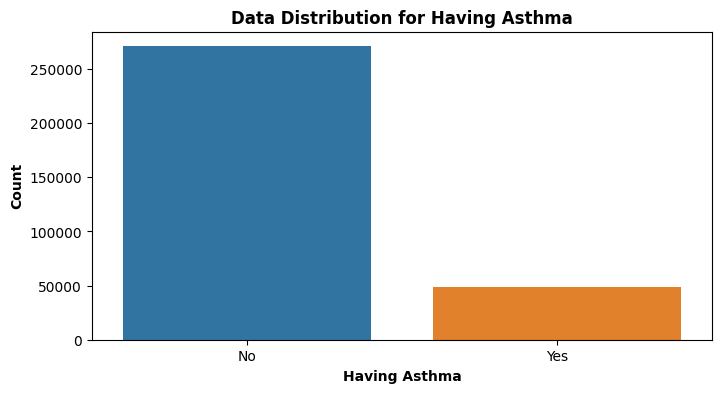

In [36]:
# Show data distribution for having asthma
dv.show_bar_graph(df=heart_disease_df, 
                  col_="HadAsthma", 
                  figure_size=(8,4),
                  title='Data Distribution for Having Asthma', 
                  x_label='Having Asthma',
                  y_label='Count')

__viii. Data Imputation for Having Skin Cancer__

Based from the results from the table below, all missing values in `HadSkinCancer` will be replaced by 'No'.

In [37]:
print("Statistical analysis for having skin cancer based on sex and age category")
skin_cancer_result = dp.get_statistical_analysis(heart_disease_df, "Sex", "AgeCategory", "HadSkinCancer")
skin_cancer_result

Statistical analysis for having skin cancer based on sex and age category


,Sex,AgeCategory,HadSkinCancer,count
0,Female,Age 18 to 24,No,6494
2,Female,Age 25 to 29,No,5897
4,Female,Age 30 to 34,No,7617
6,Female,Age 35 to 39,No,8909
8,Female,Age 40 to 44,No,9699
10,Female,Age 45 to 49,No,9458
12,Female,Age 50 to 54,No,11559
14,Female,Age 55 to 59,No,12870
16,Female,Age 60 to 64,No,16083
18,Female,Age 65 to 69,No,17658


In [38]:
print("Number of Null values in HadSkinCancer before imputation: ", heart_disease_df['HadSkinCancer'].isnull().sum())
# Imput all missing values with 'No' for all sex and age category
heart_disease_df = heart_disease_df.fillna({'HadSkinCancer': 'No'})
print("Number of Null values in HadSkinCancer after imputation: ", heart_disease_df['HadSkinCancer'].isnull().sum())

Number of Null values in HadSkinCancer before imputation:  2387


Number of Null values in HadSkinCancer after imputation:  0


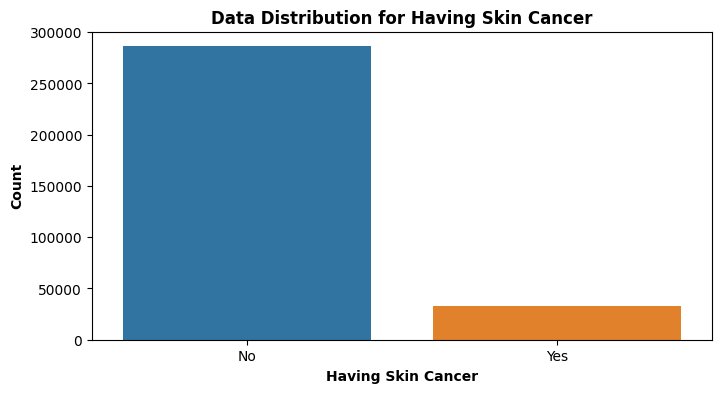

In [39]:
# Show data distribution for having skin cancer
dv.show_bar_graph(df=heart_disease_df, 
                  col_="HadSkinCancer", 
                  figure_size=(8,4),
                  title='Data Distribution for Having Skin Cancer', 
                  x_label='Having Skin Cancer',
                  y_label='Count')

__xv. Data Imputation for Having Kidney Disease__

Based from the results from the table below, all missing values in `HadKidneyDisease` will be replaced by 'No'.

In [40]:
print("Statistical analysis for having kidney disease based on sex and age category")
kidney_disease_result = dp.get_statistical_analysis(heart_disease_df, "Sex", "AgeCategory", "HadKidneyDisease")
kidney_disease_result

Statistical analysis for having kidney disease based on sex and age category


,Sex,AgeCategory,HadKidneyDisease,count
0,Female,Age 18 to 24,No,6468
2,Female,Age 25 to 29,No,5870
4,Female,Age 30 to 34,No,7592
6,Female,Age 35 to 39,No,8934
8,Female,Age 40 to 44,No,9790
10,Female,Age 45 to 49,No,9624
12,Female,Age 50 to 54,No,11972
14,Female,Age 55 to 59,No,13504
16,Female,Age 60 to 64,No,17246
18,Female,Age 65 to 69,No,19277


In [41]:
print("Number of Null values in HadkidneyDisease before imputation: ", heart_disease_df['HadKidneyDisease'].isnull().sum())
# Imput all missing values with 'No' for all sex and age category
heart_disease_df = heart_disease_df.fillna({'HadKidneyDisease': 'No'})
print("Number of Null values in HadkidneyDisease after imputation: ", heart_disease_df['HadKidneyDisease'].isnull().sum())

Number of Null values in HadkidneyDisease before imputation:  1183


Number of Null values in HadkidneyDisease after imputation:  0


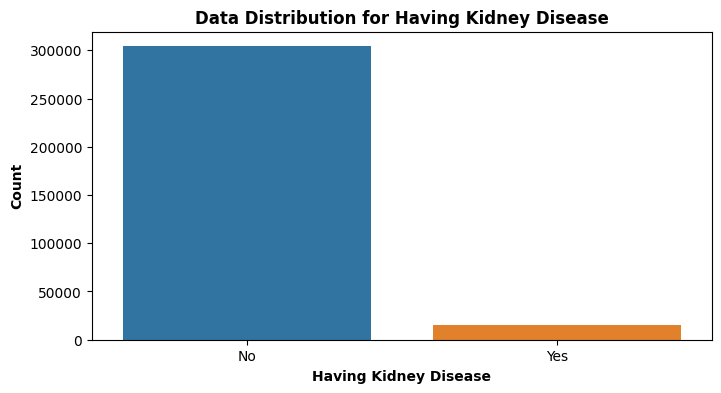

In [42]:
# Show data distribution for having kidney disease
dv.show_bar_graph(df=heart_disease_df, 
                  col_="HadKidneyDisease", 
                  figure_size=(8,4),
                  title='Data Distribution for Having Kidney Disease', 
                  x_label='Having Kidney Disease',
                  y_label='Count')

__x. Data Imputation for Smoker and Alcohol Drinker__

Based from the results below, individuals aged 75 and above who are male are mostly former smokers. Other groups indicate that there is no history of smoking.

In [43]:
print("Statistical analysis for smoker status based on sex and age category")
smoker_result = dp.get_statistical_analysis(heart_disease_df, "Sex", "AgeCategory", "SmokerStatus")
smoker_result

Statistical analysis for smoker status based on sex and age category


,Sex,AgeCategory,SmokerStatus,count
3,Female,Age 18 to 24,Never smoked,5335
7,Female,Age 25 to 29,Never smoked,4147
11,Female,Age 30 to 34,Never smoked,4761
15,Female,Age 35 to 39,Never smoked,5274
19,Female,Age 40 to 44,Never smoked,5189
23,Female,Age 45 to 49,Never smoked,5317
27,Female,Age 50 to 54,Never smoked,6819
31,Female,Age 55 to 59,Never smoked,7380
35,Female,Age 60 to 64,Never smoked,9105
39,Female,Age 65 to 69,Never smoked,10840


In [44]:
print("Number of Null values in SmokerStatus before imputation: ", heart_disease_df['SmokerStatus'].isnull().sum())
# Imput all missing values with 'No' for all sex and age category
heart_disease_df = dp.impute_smoking_status(heart_disease_df)
print("Number of Null values in SmokerStatus after imputation: ", heart_disease_df['SmokerStatus'].isnull().sum())

Number of Null values in SmokerStatus before imputation:  20860


Number of Null values in SmokerStatus after imputation:  0


In [45]:
# Show unique values under smoker status column
heart_disease_df['SmokerStatus'].value_counts().unique

<bound method Series.unique of Never smoked                             182150
Former smoker                             93376
Current smoker - now smokes every day     27397
Current smoker - now smokes some days      9095
Never smoker                               7476
Name: SmokerStatus, dtype: int64>

Combine 'Current smoker - now smokes every day' and 'Current smoker - now smokes some days' with 'Current smoker', and replace 'Never smoker' to 'Never smoked' in `SmokerStatus`

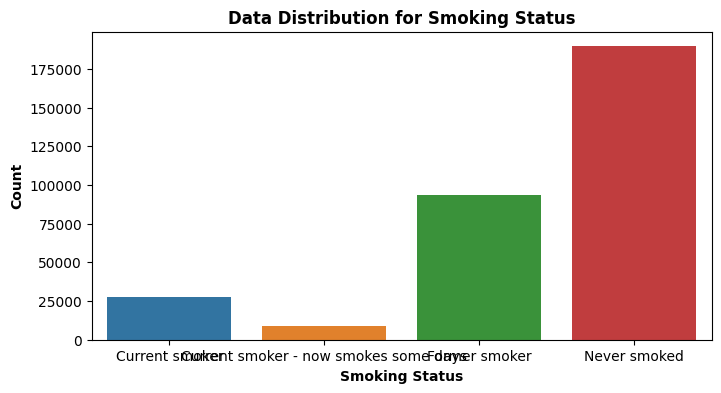

In [46]:
# conditions = ((heart_disease_df["SmokerStatus"] == "Current smoker - now smokes every day") | 
#                (heart_disease_df["SmokerStatus"] == "Current smoker - now smokes some days"))

# heart_disease_df["SmokerStatus"] = np.where(conditions, "Yes", "No")

heart_disease_df['SmokerStatus'] = heart_disease_df['SmokerStatus'].replace({
    'Never smoker': 'Never smoked',
    'Current smoker - now smokes every day': 'Current smoker',
    'Current smoker - now smokes some day': 'Current smoker',
})

# Show data distribution of having diabetes
dv.show_bar_graph(df=heart_disease_df, 
                  col_="SmokerStatus", 
                  figure_size=(8,4),
                  title='Data Distribution for Smoking Status', 
                  x_label='Smoking Status',
                  y_label='Count',
                  x_tick_rotation=None)

For the `AlcoholDrinkers` feature, the result below indicates that females aged 65 and older and males aged 80 and older predominantly do not consume alcohol. The other groups within this category are primarily characterized as regular drinkers.

In [47]:
print("Statistical analysis for alcohol drinker based on sex and age category")
alcohol_result = dp.get_statistical_analysis(heart_disease_df, "Sex", "AgeCategory", "AlcoholDrinkers")
alcohol_result

Statistical analysis for alcohol drinker based on sex and age category


,Sex,AgeCategory,AlcoholDrinkers,count
1,Female,Age 18 to 24,Yes,3464
3,Female,Age 25 to 29,Yes,3463
5,Female,Age 30 to 34,Yes,4254
7,Female,Age 35 to 39,Yes,5046
9,Female,Age 40 to 44,Yes,5488
11,Female,Age 45 to 49,Yes,5249
13,Female,Age 50 to 54,Yes,6455
15,Female,Age 55 to 59,Yes,6954
17,Female,Age 60 to 64,Yes,8554
18,Female,Age 65 to 69,No,9782


In [48]:
print("Number of Null values in AlcoholDrinkers before imputation: ", heart_disease_df['AlcoholDrinkers'].isnull().sum())
# Imput all missing values with 'No' for all sex and age category
heart_disease_df = dp.impute_alcohol_drinker(heart_disease_df)
print("Number of Null values in AlcoholDrinkers after imputation: ", heart_disease_df['AlcoholDrinkers'].isnull().sum())

Number of Null values in AlcoholDrinkers before imputation:  28599


Number of Null values in AlcoholDrinkers after imputation:  0


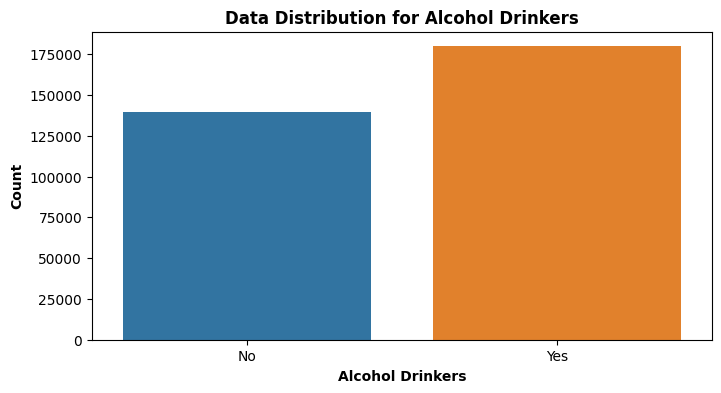

In [49]:

# Show data distribution of having diabetes
dv.show_bar_graph(df=heart_disease_df, 
                  col_="AlcoholDrinkers", 
                  figure_size=(8,4),
                  title='Data Distribution for Alcohol Drinkers', 
                  x_label='Alcohol Drinkers',
                  y_label='Count')

__xi. Data Imputation for Physically Active__

Based from the results below, all missing values in `PhysicalActivities` will be replaced by 'Yes'.

In [50]:
print("Statistical analysis for physically active group based on sex and age category")
phyactive_result = dp.get_statistical_analysis(heart_disease_df, "Sex", "AgeCategory", "PhysicalActivities")
phyactive_result

Statistical analysis for physically active group based on sex and age category


,Sex,AgeCategory,PhysicalActivities,count
1,Female,Age 18 to 24,Yes,5585
3,Female,Age 25 to 29,Yes,5049
5,Female,Age 30 to 34,Yes,6447
7,Female,Age 35 to 39,Yes,7646
9,Female,Age 40 to 44,Yes,8152
11,Female,Age 45 to 49,Yes,7778
13,Female,Age 50 to 54,Yes,9455
15,Female,Age 55 to 59,Yes,10567
17,Female,Age 60 to 64,Yes,13514
19,Female,Age 65 to 69,Yes,15129


In [51]:
print("Number of Null values in PhysicalActivities before imputation: ", heart_disease_df['PhysicalActivities'].isnull().sum())
# Imput all missing values with 'No' for all sex and age category
heart_disease_df = heart_disease_df.fillna({'PhysicalActivities': 'Yes'})
print("Number of Null values in PhysicalActivities after imputation: ", heart_disease_df['PhysicalActivities'].isnull().sum())

Number of Null values in PhysicalActivities before imputation:  737


Number of Null values in PhysicalActivities after imputation:  0


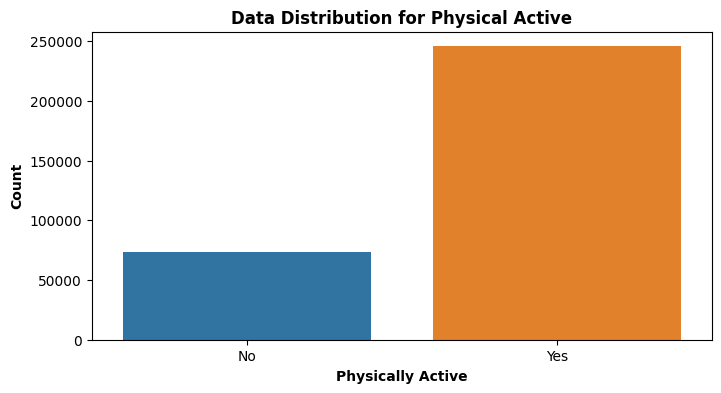

In [52]:
# Show data distribution for Physically Active
dv.show_bar_graph(df=heart_disease_df, 
                  col_="PhysicalActivities", 
                  figure_size=(8,4),
                  title='Data Distribution for Physical Active', 
                  x_label='Physically Active',
                  y_label='Count')

__xii. Data Imputation for Difficulty Walking__

Based from the results below, all missing values in `DifficultyWalking` will be replaced by 'Yes'.

In [53]:
print("Statistical analysis for difficulty of walking based on sex and age category")
diffwalking_result = dp.get_statistical_analysis(heart_disease_df, "Sex", "AgeCategory", "DifficultyWalking")
diffwalking_result

Statistical analysis for difficulty of walking based on sex and age category


,Sex,AgeCategory,DifficultyWalking,count
0,Female,Age 18 to 24,No,6015
2,Female,Age 25 to 29,No,5471
4,Female,Age 30 to 34,No,7032
6,Female,Age 35 to 39,No,8225
8,Female,Age 40 to 44,No,8860
10,Female,Age 45 to 49,No,8471
12,Female,Age 50 to 54,No,10173
14,Female,Age 55 to 59,No,11102
16,Female,Age 60 to 64,No,14051
18,Female,Age 65 to 69,No,15748


In [54]:
print("Number of Null values in DifficultyWalking before imputation: ", heart_disease_df['DifficultyWalking'].isnull().sum())
# Imput all missing values with 'No' for all sex and age category
heart_disease_df = heart_disease_df.fillna({'DifficultyWalking': 'No'})
print("Number of Null values in DifficultyWalking after imputation: ", heart_disease_df['DifficultyWalking'].isnull().sum())

Number of Null values in DifficultyWalking before imputation:  12691
Number of Null values in DifficultyWalking after imputation:  0


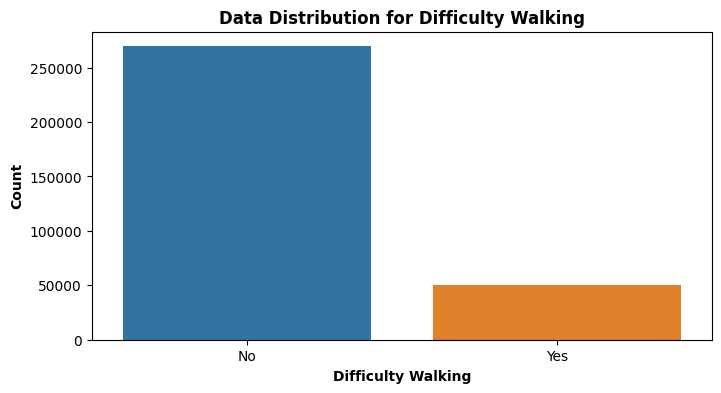

In [55]:
# Show data distribution for difficulty walking
dv.show_bar_graph(df=heart_disease_df, 
                  col_="DifficultyWalking", 
                  figure_size=(8,4),
                  title='Data Distribution for Difficulty Walking', 
                  x_label='Difficulty Walking',
                  y_label='Count')

__xiii. Data Imputation for Physical and Mental Health Days__

Based from the results below, all missing values in `PhysicalHealthDays` will be replaced by '0'.

In [56]:
print("Statistical analysis for physical health days based on sex and age category")
phyhealthdays_result = dp.get_statistical_analysis(heart_disease_df, "Sex", "AgeCategory", "PhysicalHealthDays")
phyhealthdays_result

Statistical analysis for physical health days based on sex and age category


,Sex,AgeCategory,PhysicalHealthDays,count
0,Female,Age 18 to 24,0.0,3356
31,Female,Age 25 to 29,0.0,3241
61,Female,Age 30 to 34,0.0,4124
92,Female,Age 35 to 39,0.0,5060
121,Female,Age 40 to 44,0.0,5524
152,Female,Age 45 to 49,0.0,5371
183,Female,Age 50 to 54,0.0,6755
214,Female,Age 55 to 59,0.0,7707
245,Female,Age 60 to 64,0.0,9973
276,Female,Age 65 to 69,0.0,11706


In [57]:
print("Number of Null values in PhysicalHealthDays before imputation: ", heart_disease_df['PhysicalHealthDays'].isnull().sum())
# Impute all missing values with 'No' for all sex and age category
heart_disease_df = heart_disease_df.fillna({'PhysicalHealthDays': 0})
print("Number of Null values in PhysicalHealthDays after imputation: ", heart_disease_df['PhysicalHealthDays'].isnull().sum())

Number of Null values in PhysicalHealthDays before imputation:  7269
Number of Null values in PhysicalHealthDays after imputation:  0


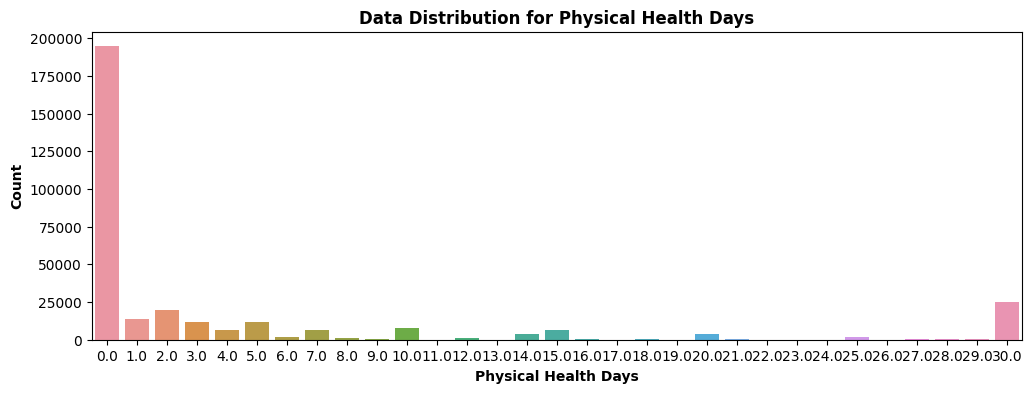

In [58]:
# Show data distribution for physical health days
dv.show_bar_graph(df=heart_disease_df, 
                  col_="PhysicalHealthDays", 
                  figure_size=(12,4),
                  title='Data Distribution for Physical Health Days', 
                  x_label='Physical Health Days',
                  y_label='Count')

Calculates the ratio of records where the value in the `PhysicalHealthDays` column is equal to 0.

In [59]:
zero_val_ratio = heart_disease_df[heart_disease_df["PhysicalHealthDays"] == 0].shape[0] / heart_disease_df.shape[0]
print(f"{round(zero_val_ratio * 100, 2)}% of the records comprise zero (0) values.")

60.92% of the records comprise zero (0) values.


Based from the results below, all missing values in `MentalHealthDays` will be replaced by '0'.

In [60]:
print("Statistical analysis for mental health days based on sex and age category")
menhealthdays_result = dp.get_statistical_analysis(heart_disease_df, "Sex", "AgeCategory", "MentalHealthDays")
menhealthdays_result

Statistical analysis for mental health days based on sex and age category


,Sex,AgeCategory,MentalHealthDays,count
0,Female,Age 18 to 24,0.0,1264
31,Female,Age 25 to 29,0.0,1514
62,Female,Age 30 to 34,0.0,2335
93,Female,Age 35 to 39,0.0,3175
124,Female,Age 40 to 44,0.0,3904
155,Female,Age 45 to 49,0.0,4240
184,Female,Age 50 to 54,0.0,5808
215,Female,Age 55 to 59,0.0,7188
245,Female,Age 60 to 64,0.0,10293
276,Female,Age 65 to 69,0.0,12591


In [61]:
print("Number of Null values in MentalHealthDays before imputation: ", heart_disease_df['MentalHealthDays'].isnull().sum())
# Impute all missing values with 'No' for all sex and age category
heart_disease_df = heart_disease_df.fillna({'MentalHealthDays': 0})
print("Number of Null values in MentalHealthDays after imputation: ", heart_disease_df['MentalHealthDays'].isnull().sum())

Number of Null values in MentalHealthDays before imputation:  6115
Number of Null values in MentalHealthDays after imputation:  0


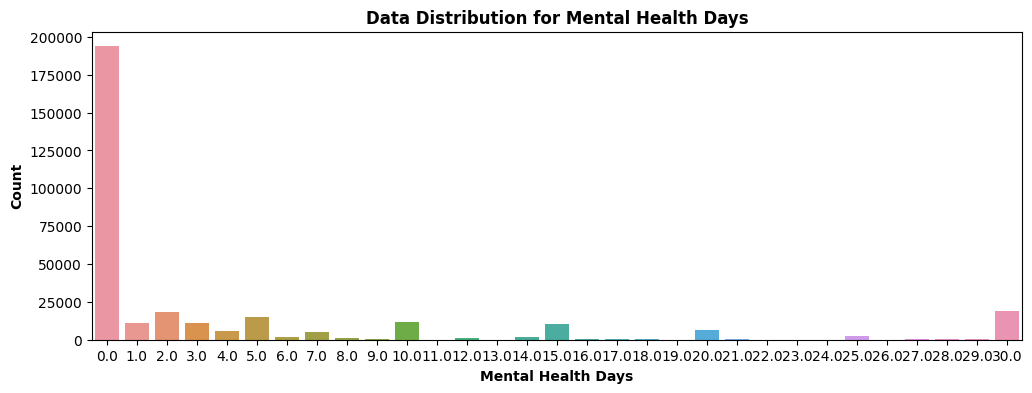

In [62]:
# Show data distribution for mental health days
dv.show_bar_graph(df=heart_disease_df, 
                  col_="MentalHealthDays", 
                  figure_size=(12,4),
                  title='Data Distribution for Mental Health Days', 
                  x_label='Mental Health Days',
                  y_label='Count')

Calculates the ratio of records where the value in the `MentalHealthDays` column is equal to 0.

In [63]:
zero_val_ratio = heart_disease_df[heart_disease_df["MentalHealthDays"] == 0].shape[0] / heart_disease_df.shape[0]
print(f"{round(zero_val_ratio * 100, 2)}% of the records comprise zero (0) values.")

60.64% of the records comprise zero (0) values.


If one category represents a significant portion of the data, it may not contribute much information to the model and can potentially lead to overfitting or bias. Hence, we'll be dropping `PhysicalHealthDays` and `MentalHealthDays` from the features.

In [64]:
heart_disease_df = heart_disease_df.drop(columns=['MentalHealthDays', 'PhysicalHealthDays'], axis=1)
print(f"Columns: {heart_disease_df.columns}")

Columns: Index(['Sex', 'GeneralHealth', 'PhysicalActivities', 'SleepHours',
       'HadHeartAttack', 'HadStroke', 'HadAsthma', 'HadSkinCancer',
       'HadKidneyDisease', 'HadDiabetes', 'DifficultyWalking', 'SmokerStatus',
       'RaceEthnicityCategory', 'AgeCategory', 'HeightInMeters',
       'WeightInKilograms', 'BMI', 'AlcoholDrinkers', 'WeightStatus'],
      dtype='object')


__xiv. Data Imputation for Sleeping Hours__

Based from the results below, individuals aged 65 years and older have an average sleep duration of 8 hours, while other age groups typically sleep for seven hours on average.

In [65]:
print("Statistical analysis for sleep hours based on sex and age category")
menhealthdays_result = dp.get_statistical_analysis(heart_disease_df, "Sex", "AgeCategory", "SleepHours")
menhealthdays_result

Statistical analysis for sleep hours based on sex and age category


,Sex,AgeCategory,SleepHours,count
6,Female,Age 18 to 24,7.0,1947
24,Female,Age 25 to 29,7.0,1862
41,Female,Age 30 to 34,7.0,2379
61,Female,Age 35 to 39,7.0,3063
79,Female,Age 40 to 44,7.0,3321
98,Female,Age 45 to 49,7.0,3271
118,Female,Age 50 to 54,7.0,3931
139,Female,Age 55 to 59,7.0,4532
161,Female,Age 60 to 64,7.0,5726
181,Female,Age 65 to 69,8.0,6329


In [66]:
print("Number of Null values in SleepHours before imputation: ", heart_disease_df['SleepHours'].isnull().sum())
# Impute sleep hours based on sex and weight status
heart_disease_df = dp.impute_sleep_hours(heart_disease_df)
print("Number of Null values in SleepHours after imputation: ", heart_disease_df['SleepHours'].isnull().sum())

Number of Null values in SleepHours before imputation:  3388
ERROR: name 'choices' is not defined
Number of Null values in SleepHours after imputation:  3388


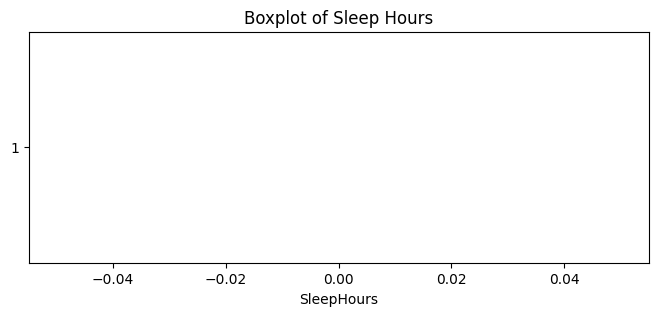

In [67]:
sleep_hours = heart_disease_df['SleepHours'].tolist()
sleep_hours = pd.to_numeric(sleep_hours, errors='coerce')
dv.show_boxplot_graph(data=sleep_hours, figure_size=(8,3),title='Boxplot of Sleep Hours', x_label='SleepHours')

We will eliminate any outliers present in the dataset to enhance the accuracy and reliability of our analysis.

In [68]:
heart_disease_df = heart_disease_df[(heart_disease_df['SleepHours'] >= 3) & (heart_disease_df['SleepHours'] <= 11)]
print(f"Min Sleep Hours: {heart_disease_df['SleepHours'].min()}, Max Sleep Hours: {heart_disease_df['SleepHours'].max()}")

Min Sleep Hours: 3.0, Max Sleep Hours: 11.0


Remove redundant features, i.e. WeightStatus, HeightInMeters, WeightInKilograms, as they are solely utilized for BMI calculation and imputation of the person's age category and general health. Furthermore, given that we restrict the RaceEthnicityCategory to 'White only, Non-Hispanic', we will exclude this feature from consideration since it contains only a one value.

In [69]:
columns_to_drop = ['WeightStatus', 'RaceEthnicityCategory', 'HeightInMeters', 'WeightInKilograms']
heart_disease_df = heart_disease_df.drop(columns=columns_to_drop)
print(f"Columns: {heart_disease_df.columns}")

Columns: Index(['Sex', 'GeneralHealth', 'PhysicalActivities', 'SleepHours',
       'HadHeartAttack', 'HadStroke', 'HadAsthma', 'HadSkinCancer',
       'HadKidneyDisease', 'HadDiabetes', 'DifficultyWalking', 'SmokerStatus',
       'AgeCategory', 'BMI', 'AlcoholDrinkers'],
      dtype='object')


Show the statistical analysis of the data post data preprocessing.

In [70]:
heart_disease_df.head()

,Sex,GeneralHealth,PhysicalActivities,SleepHours,HadHeartAttack,HadStroke,HadAsthma,HadSkinCancer,HadKidneyDisease,HadDiabetes,DifficultyWalking,SmokerStatus,AgeCategory,BMI,AlcoholDrinkers
0,Female,Very good,No,8.0,No,No,No,No,No,Yes,No,Never smoked,Age 80 or older,25.515625,No
1,Female,Excellent,No,6.0,No,No,No,Yes,No,No,No,Never smoked,Age 80 or older,26.570000,No
2,Female,Very good,Yes,5.0,No,No,No,Yes,No,No,No,Never smoked,Age 55 to 59,25.610000,No
3,Female,Excellent,Yes,7.0,No,No,Yes,No,No,No,No,Current smoker - now smokes some days,Age 80 or older,23.300000,No
4,Female,Fair,Yes,9.0,No,No,No,No,No,No,No,Never smoked,Age 40 to 44,21.770000,Yes


### __Dimentionality Reduction__

In machine learning, dimensionality reduction is a method employed to decrease the number of features or variables in a dataset while maintaining crucial information or patterns. The aim is to streamline the data without sacrificing essential details or impacting the performance of machine learning models.

### __Feature Engineering__

##### __Encoding Categorical Features__

Transform all categorical attributes into binary dummy variables where the value is 0 (representing No) or 1 (representing Yes).

In [71]:
# Get all categorical columns
categorical_columns = [name for name in heart_disease_df.columns if heart_disease_df[name].dtype=='O']

print(f'There are {len(categorical_columns)} categorical features:\n')
print(", ".join(categorical_columns))

There are 13 categorical features:

Sex, GeneralHealth, PhysicalActivities, HadHeartAttack, HadStroke, HadAsthma, HadSkinCancer, HadKidneyDisease, HadDiabetes, DifficultyWalking, SmokerStatus, AgeCategory, AlcoholDrinkers


In [72]:
feature_no_drop = ['GeneralHealth', 'AgeCategory', 'RaceEthnicityCategory']

categorical_drop_first = [name for name in categorical_columns if name not in feature_no_drop]
categorical_no_drop = [name for name in categorical_columns if name in feature_no_drop]

heart_disease_df_dummy = pd.get_dummies(data=heart_disease_df, columns=categorical_drop_first, drop_first=True)
heart_disease_df_dummy = pd.get_dummies(data=heart_disease_df_dummy, columns=categorical_no_drop)
heart_disease_df_dummy.head(5)

,SleepHours,BMI,Sex_Male,PhysicalActivities_Yes,HadHeartAttack_Yes,HadStroke_Yes,HadAsthma_Yes,HadSkinCancer_Yes,HadKidneyDisease_Yes,HadDiabetes_Yes,...,AgeCategory_Age 35 to 39,AgeCategory_Age 40 to 44,AgeCategory_Age 45 to 49,AgeCategory_Age 50 to 54,AgeCategory_Age 55 to 59,AgeCategory_Age 60 to 64,AgeCategory_Age 65 to 69,AgeCategory_Age 70 to 74,AgeCategory_Age 75 to 79,AgeCategory_Age 80 or older
0,8.0,25.515625,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,6.0,26.570000,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,5.0,25.610000,0,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
3,7.0,23.300000,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,9.0,21.770000,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


##### __Splitting Dataset to Train, Test and Validation__

There are a total of 301,758 records. Divide the data into training and testing sets, with 20% reserved for testing.

In [73]:
# Split into feature variable and target variable
X = heart_disease_df_dummy.drop(columns='HadHeartAttack_Yes')
y = heart_disease_df_dummy['HadHeartAttack_Yes']

In [74]:
# Split the data into training and testing sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split training dataset into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

print(f"Shape of the train dataset: ({X_train.shape}, {y_train.shape})")
print(f"Shape of the validation dataset: ({X_val.shape}, {y_val.shape})")
print(f"Shape of the test dataset: ({X_test.shape}, {y_test.shape})")

Shape of the train dataset: ((199436, 32), (199436,))
Shape of the validation dataset: ((49859, 32), (49859,))
Shape of the test dataset: ((62324, 32), (62324,))


##### __Balancing Class Distribution__

Synthetic data will be generated using SMOTE, as previously stated, to achieve a balanced distribution of data across all classes. The value of k_neighbors to be used will be 60, which provided the highest score during the hyperparameter tuning process for k-nearest neighbors.

In [75]:
# smote = SMOTE(k_neighbors=42, random_state=42)
# print(f"{smote}")

The original count of records for the 'with Heart Disease' class has now been balanced with the 'without Heart Disease' class, resulting in a total of 152,718 records for both classes

In [76]:
# X_train_smoted, y_train_smoted = smote.fit_resample(X_train, y_train)

# print(f'No. of records before using SMOTE\n{y_train.value_counts()}\n')
# print(f'No. of records after using SMOTE\n{y_train_smoted.value_counts()}')

In [77]:
from imblearn.combine import SMOTEENN
sme = SMOTEENN(random_state=42)

In [78]:
X_train_smoted, y_train_smoted = sme.fit_resample(X_train, y_train)

print(f'No. of records before using SMOTE\n{y_train.value_counts()}\n')
print(f'No. of records after using SMOTE\n{y_train_smoted.value_counts()}')

No. of records before using SMOTE
0    187234
1     12202
Name: HadHeartAttack_Yes, dtype: int64

No. of records after using SMOTE
1    171989
0    146574
Name: HadHeartAttack_Yes, dtype: int64


##### __Scaling Dataset__

Scaling the dataset is important for machine learning models as it ensures that features with different scales contribute equally. Standardization, a scaling technique, enhances model performance by transforming features to have zero mean and unit variance, promoting stable and efficient learning. Scaling is done before data normalization to avoid data leakage, when information outside the training dataset is used to create a model.

In [79]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train_smoted)
X_test_sc = scaler.transform(X_test)
X_val_sc = scaler.transform(X_val)

### __Model Creation and Evaluation__

The  objective is to predict whether an individual has heart disease, which falls under a classification problem. For the model training phase, four distinct classification algorithms are used.

- Logistic Regression
- Decision Tree
- Artificial Neural Network (ANN)

##### __Logistic Regression__

Logistic regression is a statistical method used for binary classification, predicting the probability of an observation belonging to one of two classes. It models the relationship between the input features and the likelihood of the outcome using the logistic function.

In [80]:
LR_model = LogisticRegression()

# Define a grid of hyperparameter values to search
param_grid = {
    'penalty': ['l1'],
    'C': [0.001, 0.01, 0.1, 1, 10],
    'solver': ['lbfgs', 'liblinear', 'saga']
}

grid_search = GridSearchCV(LR_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_sc, y_train_smoted)

# Best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Best logistic regression model
best_LR_model = grid_search.best_estimator_
print(f"Best model: {best_LR_model}")

Best hyperparameters: {'C': 10, 'penalty': 'l1', 'solver': 'saga'}
Best model: LogisticRegression(C=10, penalty='l1', solver='saga')


Classification Report of Test Dataset

              precision    recall  f1-score   support

           0       0.97      0.74      0.84     58466
           1       0.15      0.70      0.25      3858

    accuracy                           0.74     62324
   macro avg       0.56      0.72      0.55     62324
weighted avg       0.92      0.74      0.81     62324



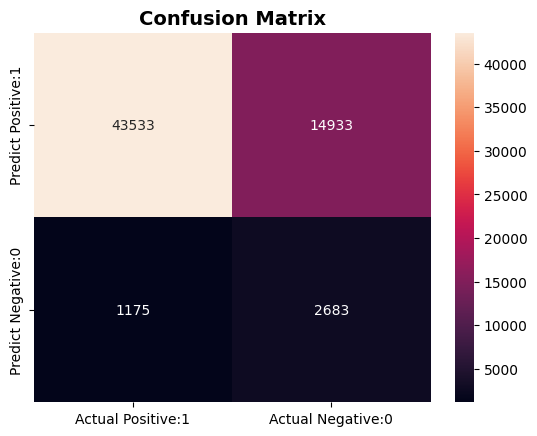

In [81]:
def evaluation_metrics(model, X, y):
    y_pred = model.predict(X)

    print("Classification Report of Test Dataset\n")
    print(classification_report(y, y_pred))

    cm = confusion_matrix(y, y_pred)
    TN, FP, FN, TP = cm.ravel()

    cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], index=['Predict Positive:1', 'Predict Negative:0'])
    sns.heatmap(cm_matrix, annot=True, fmt='d')
    plt.title('Confusion Matrix', fontsize=14, fontweight='bold')


evaluation_metrics(best_LR_model, X_test_sc, y_test)

##### __Decision Tree Classifier__

A decision tree classifier is a predictive modeling algorithm that recursively partitions data based on feature conditions, constructing a tree-like structure to make sequential decisions and assign classifications to instances. It is widely used for both classification and regression tasks in machine learning.

In [ ]:
DT_model = DecisionTreeClassifier()

# Define a grid of hyperparameter values to search
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

grid_search = GridSearchCV(DT_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Best logistic regression model
best_DT_model = grid_search.best_estimator_
print(f"Best model: {best_DT_model}")

Classification Report of Test Dataset

              precision    recall  f1-score   support

           0       0.96      0.85      0.90     58466
           1       0.15      0.40      0.21      3858

    accuracy                           0.82     62324
   macro avg       0.55      0.62      0.56     62324
weighted avg       0.91      0.82      0.85     62324



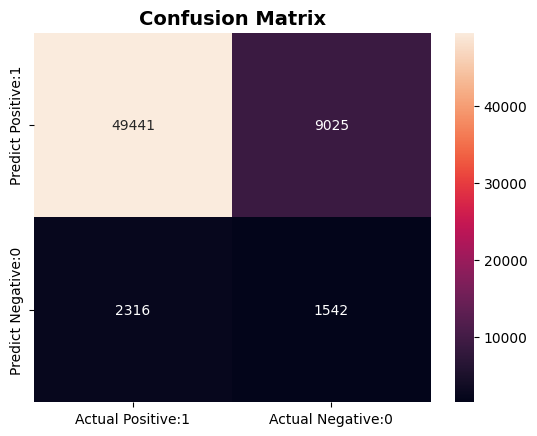

In [83]:
evaluation_metrics(best_DT_model, X_test_sc, y_test)

##### __Artificial Neural Network (ANN)__

In [84]:
# Design the architecture of the neural network
Layers = [
    Dense(units=30, activation="sigmoid", input_shape=X_train_sc.shape[1:], name='InputLayer'),
    BatchNormalization(name='BatchNormalization1'),
    Dense(units=30, activation="sigmoid", name='HiddenLayer1'),
    BatchNormalization(name='BatchNormalization2'),
    Dense(units=15, activation="sigmoid", name='HiddenLayer2'),
    Dense(units=2, name='OutputLayer')
]

ANN_model = Sequential(Layers)
ANN_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (Dense)          (None, 30)                990       
                                                                 
 BatchNormalization1 (Batch  (None, 30)                120       
 Normalization)                                                  
                                                                 
 HiddenLayer1 (Dense)        (None, 30)                930       
                                                                 
 BatchNormalization2 (Batch  (None, 30)                120       
 Normalization)                                                  
                                                                 
 HiddenLayer2 (Dense)        (None, 15)                465       
                                                                 
 OutputLayer (Dense)         (None, 2)                 

In [85]:
# Compile the ANN model
ANN_model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

In [86]:
EPOCHS = 40
# Train the model with validation on the training set
history = ANN_model.fit(X_train_sc, y_train_smoted, epochs=EPOCHS, validation_data=(X_val_sc, y_val))

Epoch 1/40


9956/9956 [==============================] - 24s 2ms/step - loss: 0.5268 - accuracy: 0.4025 - val_loss: 0.6199 - val_accuracy: 0.7431
Epoch 2/40
9956/9956 [==============================] - 23s 2ms/step - loss: 0.3668 - accuracy: 0.4894 - val_loss: 0.5960 - val_accuracy: 0.9140
Epoch 3/40
9956/9956 [==============================] - 23s 2ms/step - loss: 0.3484 - accuracy: 0.5543 - val_loss: 0.5049 - val_accuracy: 0.4614
Epoch 4/40
9956/9956 [==============================] - 22s 2ms/step - loss: 0.3389 - accuracy: 0.4849 - val_loss: 0.5069 - val_accuracy: 0.7999
Epoch 5/40
9956/9956 [==============================] - 22s 2ms/step - loss: 0.3296 - accuracy: 0.5489 - val_loss: 0.4938 - val_accuracy: 0.1500
Epoch 6/40
9956/9956 [==============================] - 20s 2ms/step - loss: 0.3276 - accuracy: 0.5412 - val_loss: 0.5897 - val_accuracy: 0.2253
Epoch 7/40
9956/9956 [==============================] - 20s 2ms/step - loss: 0.3335 - accuracy: 0.5264 - val_loss: 0.5838 - val_

### __Hyper Parameter Tuning__

### __References__

- https://towardsdatascience.com/apache-spark-performance-boosting-e072a3ec1179
- https://medium.com/@adrianchang/apache-spark-checkpointing-ebd2ec065371